In [1]:
# Packages
using Knet, AutoGrad, LinearAlgebra, Base.Iterators, Statistics, Random, StatsBase, IterTools, Plots

In [2]:
# Constants
ENV["COLUMNS"] = 64
ARRAY=Array{Float64} # KnetArray{Float32}
UPDATE=true # keep this true (false only useful for checking gradients)
BSIZE=1     # keep batchsize=1 until larger ones supported
XSIZE=28*28
YSIZE=10
HSIZE=[64]
ALPHA=100.0
GAMMA=0.0001
LAMBDA=0.995
ETA=0.1
MU0=0.0001

0.0001

In [3]:
# Load minibatched MNIST data:
include(Knet.dir("data","mnist.jl"))
dtrn, dtst = mnistdata(xtype=ARRAY, batchsize=BSIZE)
xtrn, ytrn, xtst, ytst = mnist()
xtrn = ARRAY(reshape(xtrn,(XSIZE,:)))
xtst = ARRAY(reshape(xtst,(XSIZE,:)));

┌ Info: Loading MNIST...
└ @ Main /home/ec2-user/.julia/dev/Knet/data/mnist.jl:33


In [4]:
# Model definition and initialization
struct MLP; W; b; μ; B; g; ∇g;
    function MLP(dims...;α=ALPHA)
        h,o = dims[end-1:end]
        W = initw.(dims[1:end-1],dims[2:end])
        b = initb.(dims[2:end])
        μ = initμ(h,o)
        B = initB(h,o;α=α)
        g = initg(μ,B)
        ∇g = init∇g(h)
        new(W, b, μ, B, g, ∇g)
    end
end

initw(i,o)=Param(ARRAY(xavier(o,i)))
initb(o)=Param(ARRAY(zeros(o)))
initμ(h,o)=ARRAY(MU0*randn(h,o))
initB(h,o;α=ALPHA)=(B = zeros(h,h,o); for i in 1:o, j in 1:h; B[j,j,i] = α; end; ARRAY(B))
init∇g(h)=ARRAY(zeros(h))

function initg(μ,B)
    g,M = 0,size(μ,2)
    for k in 1:M, j in 1:M
        k==j && continue
        Δμ = μ[:,k] - μ[:,j]
        g += log(Δμ' * B[:,:,k] * Δμ)
    end
    return [ -g ]
end

Base.show(io::IO, m::MLP)=print(IOContext(io,:compact=>true), "MLP", (size(m.W[1],2),length.(m.b)...))

In [5]:
# Featurevec, predict and loss functions
function featurevector(m::MLP,x)
    L,y = length(m.W),mat(x)
    for l in 1:L-1
        y = relu.(m.b[l] .+ m.W[l] * y)
    end
    return y
end

function (m::MLP)(x) # predict
    m.b[end] .+ m.W[end] * featurevector(m,x)
end

function (m::MLP)(x,labels;γ=GAMMA) # loss
    @assert length(labels)==1 "Batchsize > 1 not implemented yet."
    yfeat = featurevector(m,x)
    ypred = m.b[end] .+ m.W[end] * yfeat
    J = nll(ypred,labels)
    g = discriminantregularizer(yfeat,labels,m)
    return J + γ * g
end

In [6]:
function discriminantregularizer(y,labels,m; λ=LAMBDA, η=ETA, update=UPDATE)
    y = vec(y)
    M = size(m.μ,2)
    β = labels[1]     # β(n) class label for the nth sample
    μᵦ₀ = m.μ[:,β]    # μ[β(n)](n-1) exponentially weighted mean of class β(n) before the nth sample
    Bᵦ₀ = m.B[:,:,β]  # B[β(n)](n-1) exponentially weighted inverse covariance matrix of class β(n) before the nth sample
    μᵦ₁  = λ * μᵦ₀ + (1-λ) * y
    y₀ = y - μᵦ₀      # ybar[L-1](n) the centralized feature vector
    z = Bᵦ₀ * y₀      # unscaled gradient
    ξ = 1 / ((1/(1-λ)) + (y₀' * Bᵦ₀ * y₀))  # gradient scaling
    A = (1/λ)*(Bᵦ₀ - z*z'*ξ)
    Bᵦ₁ = A-(1-λ)*η*A*A/(1+(1-λ)*η*tr(A))  # updated inverse covariance matrix  
    ∇g=0*y          # 0*y matches y's array type, zeros(size(y)) may not.
    g = m.g[1]
    for j=1:M 
        if (j!=β)
            μⱼ=m.μ[:,j]
            Bⱼ=m.B[:,:,j]
            Δμⱼ₀=μᵦ₀-μⱼ
            Δμⱼ₁=μᵦ₁-μⱼ
            αⱼ₀=(Δμⱼ₀'*Bᵦ₀*Δμⱼ₀)
            αⱼ₁=(Δμⱼ₁'*Bᵦ₁*Δμⱼ₁)
            ζⱼ₀=(Δμⱼ₀'*Bⱼ*Δμⱼ₀)
            ζⱼ₁=(Δμⱼ₁'*Bⱼ*Δμⱼ₁)
            g=g-log(αⱼ₁)+log(αⱼ₀)-log(ζⱼ₁)+log(ζⱼ₀)
            qⱼ=Bᵦ₁*Δμⱼ₁
            ∇g+=Bⱼ*Δμⱼ₁/(Δμⱼ₁'*Bⱼ*Δμⱼ₁)+qⱼ*(1-qⱼ'*(y-μᵦ₁))/αⱼ₁
        end
    end
            
    if training()  # Store ∇g if differentiating
        m.∇g .= -2*(1-λ)*∇g
    end
    
    if update      # Update state if specified
        m.g[1] = g
        m.B[:,:,β] .= Bᵦ₁
        m.μ[:,β] .= μᵦ₁
    end

    return g
end

@primitive discriminantregularizer(y,l,m;o...),dy  dy*m.∇g

In [7]:
# Experiment 1: check model functions
UPDATE=false
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
@show x |> summary
@show labels
@show (y = featurevector(m,x)) |> summary
@show (scores = m(x)) |> summary
@show J=nll(scores,labels)
@show g=discriminantregularizer(y,labels,m)
@show J + GAMMA * g
@show m(x,labels)
UPDATE=true;

x |> summary = "28×28×1×1 Array{Float64,4}"
labels = UInt8[0x05]
(y = featurevector(m, x)) |> summary = "64×1 Array{Float64,2}"
(scores = m(x)) |> summary = "10×1 Array{Float64,2}"
J = nll(scores, labels) = 2.3873872863590675
g = discriminantregularizer(y, labels, m) = 747.9247785367795
J + GAMMA * g = 2.4621797642127454
m(x, labels) = 2.4621797642127454


In [8]:
# Experiment 2: check gradients
using AutoGrad: @gcheck, gcheck
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
y = featurevector(m,x)
py = Param(y)
UPDATE=false
@show @gcheck discriminantregularizer(py,labels,m)
@show @gcheck nll(m(x),labels)
@show @gcheck m(x,labels)
UPDATE=true

discriminantregularizer(py, labels, m) = 754.443782327036
#= In[8]:9 =# @gcheck(discriminantregularizer(py, labels, m)) = true
#= In[8]:10 =# @gcheck(nll(m(x), labels)) = true
#= In[8]:11 =# @gcheck(m(x, labels)) = true


0.0001

In [9]:
# Experiment 3: train one epoch with regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA=0.01
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst),g=initg(m.μ, m.B))

-4.59e+00  100.00%┣████████┫ 10000/10000 [01:04/01:04, 157.47i/s]


(acc = 0.9064, nll = 0.29463243110945503, g = [-458.52])

In [10]:
# Experiment 4: train one epoch without regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA = 0
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst),g=initg(m.μ, m.B))

2.56e-05  100.00%┣█████████┫ 10000/10000 [00:55/00:55, 182.30i/s]


(acc = 0.9198, nll = 0.2600133985319897, g = [-457.735])

In [11]:
# Experiment 5: run to convergence with 100 instances, no regularization
Random.seed!(1)
d100 = take(dtrn,100)
countmap([Int(y[1]) for (x,y) in d100]) |> println # make sure labels are balanced
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA = 0
a5 = collect(progress((adam!(m,d100);accuracy(m(xtst),ytst)) for i in 1:100))
findmax(a5)

Dict(7=>10,4=>11,9=>11,10=>13,2=>6,3=>11,5=>5,8=>8,6=>11,1=>14)
6.89e-01  100.00%┣██████████████▉┫ 100/100 [01:17/01:17, 1.29i/s]


(0.689, 21)

In [17]:
# Experiment 5b: run to convergence with 100 instances, default regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA = 0.0001
a5b = collect(progress((adam!(m,d100);accuracy(m(xtst),ytst)) for i in 1:100))
findmax(a5b)

6.87e-01  100.00%┣██████████████▉┫ 100/100 [00:29/00:29, 3.40i/s]


(0.6886, 45)

In [18]:
@doc goldensection

```
goldensection(f,n;kwargs) => (fmin,xmin)
```

Find the minimum of `f` using concurrent golden section search in `n` dimensions. See `Knet.goldensection_demo()` for an example.

`f` is a function from a `Vector{Float64}` of length `n` to a `Number`.  It can return `NaN` for out of range inputs.  Goldensection will always start with a zero vector as the initial input to `f`, and the initial step size will be 1 in each dimension.  The user should define `f` to scale and shift this input range into a vector meaningful for their application. For positive inputs like learning rate or hidden size, you can use a transformation such as `x0*exp(x)` where `x` is a value `goldensection` passes to `f` and `x0` is your initial guess for this value. This will effectively start the search at `x0`, then move with multiplicative steps.

I designed this algorithm combining ideas from [Golden Section Search](http://apps.nrbook.com/empanel/index.html?pg=492) and [Hill Climbing Search](https://en.wikipedia.org/wiki/Hill_climbing). It essentially runs golden section search concurrently in each dimension, picking the next step based on estimated gain.

# Keyword arguments

  * `dxmin=0.1`: smallest step size.
  * `accel=φ`: acceleration rate. Golden ratio `φ=1.618...` is best.
  * `verbose=false`: use `true` to print individual steps.
  * `history=[]`: cache of `[(x,f(x)),...]` function evaluations.


In [21]:
# Experiment 6: find best γ for 100 instances
function evalgamma(loggamma)
    global GAMMA = exp(loggamma[1]-6)
    results = []
    for i in 1:5
        Random.seed!(i)
        m = MLP(XSIZE,HSIZE...,YSIZE)
        a = [ (adam!(m,d100); accuracy(m(xtst),ytst)) for i in 1:100 ]
        println((GAMMA,findmax(a)...))
        push!(results, maximum(a))
    end
    @show -mean(results)
end

# best = (0.0005)
results6 = []
goldensection(evalgamma,1; history=results6)

(0.0024787521766663585, 0.6904, 21)
(0.0024787521766663585, 0.6906, 94)
(0.0024787521766663585, 0.6898, 26)
(0.0024787521766663585, 0.6904, 100)
(0.0024787521766663585, 0.6881, 38)
(0.006737946999085467, 0.6919, 69)
(0.006737946999085467, 0.6875, 26)
(0.006737946999085467, 0.6956, 98)
(0.006737946999085467, 0.6846, 89)
(0.006737946999085467, 0.6887, 77)
(0.0013360550645321028, 0.692, 21)
(0.0013360550645321028, 0.6917, 99)
(0.0013360550645321028, 0.6954, 43)
(0.0013360550645321028, 0.6887, 99)
(0.0013360550645321028, 0.686, 30)
(0.0004915071905143453, 0.6927, 42)
(0.0004915071905143453, 0.6924, 89)
(0.0004915071905143453, 0.695, 91)
(0.0004915071905143453, 0.6883, 100)
(0.0004915071905143453, 0.6867, 47)
(9.746005292558201e-5, 0.6924, 100)
(9.746005292558201e-5, 0.691, 73)
(9.746005292558201e-5, 0.6952, 57)
(9.746005292558201e-5, 0.6884, 93)
(9.746005292558201e-5, 0.6865, 33)
(0.0002649238908682664, 0.6914, 89)
(0.0002649238908682664, 0.6909, 72)
(0.0002649238908682664, 0.6945, 71)
(0.

InterruptException: InterruptException:

In [ ]:
# Experiment 7: run to convergence with 1000 instances, no regularization
Random.seed!(1)
d1000 = take(dtrn,1000)
countmap([Int(y[1]) for (x,y) in d1000]) |> println # make sure labels balanced
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA,UPDATE = 0,false
a = collect(progress((adam!(m,d1000);accuracy(m(xtst),ytst)) for i in 1:100))
UPDATE=true
findmax(a)

In [ ]:
# Experiment 8: find best γ for 1000 instances
function evalgamma(loggamma)
    global GAMMA = exp(loggamma[1]-6)
    results = []
    for i in 1:5
        Random.seed!(i)
        m = MLP(XSIZE,HSIZE...,YSIZE)
        a = [ (adam!(m,d1000); accuracy(m(xtst),ytst)) for i in 1:30 ]
        println((GAMMA,findmax(a)...))
        push!(results, maximum(a))
    end
    @show -mean(results)
end

# best = ()
results8 = []
goldensection(evalgamma,1; history=results8)

In [23]:
# Experiment 9: compute learning curve
# Hyperparameter optimization failed, using γ1=γ2=0.01 as default
# Compare with/without regularization for various dataset sizes
# 1. Regularization has a slight advantage for small sizes (may be more significant with hyperparam optimization)
# 2. The advantage reduces, disappears as dataset size gets bigger
# 3. We get a negative log problem at n=1024
results9 = Dict()
for p in 5:15, g in (0,0.1)
    data = take(dtrn,2^p)
    GAMMA = g
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,data); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((n=2^p,γ=g,acc=maximum(a)))
    results9[(n=2^p,γ=g)] = a
end

(n = 32, γ = 0, acc = 0.5578)
(n = 32, γ = 0.1, acc = 0.5667)
(n = 64, γ = 0, acc = 0.6832)
(n = 64, γ = 0.1, acc = 0.684)
(n = 128, γ = 0, acc = 0.7236)
(n = 128, γ = 0.1, acc = 0.7251)
(n = 256, γ = 0, acc = 0.798)
(n = 256, γ = 0.1, acc = 0.8038)
(n = 512, γ = 0, acc = 0.8546)

Stacktrace:
 [1] throw_complex_domainerror(::Symbol, ::Float64) at ./math.jl:31
 [2] log(::Float64) at ./special/log.jl:285
 [3] #discriminantregularizer#8(::Float64, ::Float64, ::Bool, ::Function, ::Array{Float64,2}, ::Array{UInt8,1}, ::MLP) at ./In[6]:25
 [4] discriminantregularizer(::Array{Float64,2}, ::Array{UInt8,1}, ::MLP) at ./In[6]:2
 [5] #forw#1(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::AutoGrad.Result{Array{Float64,2}}, ::Vararg{Any,N} where N) at /home/ec2-user/.julia/dev/AutoGrad/src/core.jl:66
 [6] forw at /home/ec2-user/.julia/dev/AutoGrad/src/core.jl:65 [inlined]
 [7] #discriminantregularizer#33 at ./none:0 [inlined]
 [8] discriminantregul

DomainError: DomainError with -4785.370673026404:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [ ]:
#= Learning curve:
(n = 32, γ = 0, acc = 0.5578)
(n = 32, γ = 0.1, acc = 0.5667)
(n = 64, γ = 0, acc = 0.6832)
(n = 64, γ = 0.1, acc = 0.684)
(n = 128, γ = 0, acc = 0.7236)
(n = 128, γ = 0.1, acc = 0.7251)
(n = 256, γ = 0, acc = 0.798)
(n = 256, γ = 0.1, acc = 0.8038)
(n = 512, γ = 0, acc = 0.8546)

=#

In [24]:
# Experiment 10: Compute training curve with no regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0, false
m0 = MLP(XSIZE,HSIZE...,YSIZE)
r0 = collect(progress(accuracy(m0(xtst),ytst) for z in 
             takenth(adam(m0,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.55e-01  100.00%┣█████████████████┫ 60/60 [03:49/03:49, 3.82s/i]


In [25]:
# Experiment 11: Compute training curve with regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0.1, true
m1 = MLP(XSIZE,HSIZE...,YSIZE)
r1 = collect(progress(accuracy(m1(xtst),ytst) for z in 
             takenth(adam(m1,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.46e-01  100.00%┣█████████████████┫ 60/60 [03:33/03:33, 3.55s/i]


In [26]:
# Experiment 12: Compute training curve with regularization after an initial period
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0, false
m2 = MLP(XSIZE,HSIZE...,YSIZE)
r2 = collect(progress(
        (a=accuracy(m2(xtst),ytst); if a>0.9; global GAMMA,UPDATE=0.1,true; end; a)
        for z in takenth(adam(m2,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.52e-01  100.00%┣█████████████████┫ 60/60 [03:51/03:51, 3.85s/i]


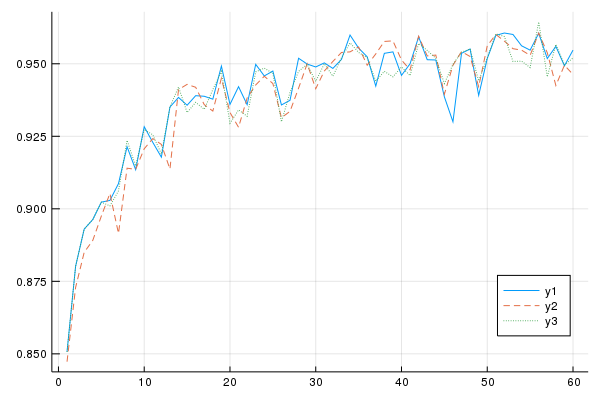

In [27]:
# Plot training curves
Plots.default(fmt=:png,ls=:auto,legend=:bottomright)
plot([r0 r1 r2])

In [ ]:
# Macro for debugging
macro summ(exs...)
    blk = Expr(:block)
    for ex in exs
        push!(blk.args, :(println($(sprint(Base.show_unquoted,ex)*" = "),
                                  summ(begin value=$(esc(ex)) end))))
    end
    isempty(exs) || push!(blk.args, :value)
    return blk
end
summ(x)=(x isa Number ? repr(x) : summary(x))
#macro summ(exs...); esc(exs[1]); end

#=
y = vec(y) = 64-element Array{Float64,1}
M = size(m.μ, 2) = 10
β = labels[1] = 0x05
μᵦ₀ = m.μ[:, β] = 64-element Array{Float64,1}
Bᵦ₀ = m.B[:, :, β] = 64×64 Array{Float64,2}
μᵦ₁ = λ * μᵦ₀ + (1 - λ) * y = 64-element Array{Float64,1}
y₀ = y - μᵦ₀ = 64-element Array{Float64,1}
z = Bᵦ₀ * y₀ = 64-element Array{Float64,1}
ξ = 1 / (1 / (1 - λ) + y₀' * Bᵦ₀ * y₀) = 0.002133886953265167
A = (1 / λ) * (Bᵦ₀ - z * z' * ξ) = 64×64 Array{Float64,2}
Bᵦ₁ = A - ((1 - λ) * η * A * A) / (1 + (1 - λ) * η * tr(A)) = 64×64 Array{Float64,2}
∇g = 0y = 64-element Array{Float64,1}
g = m.g[1] = 814.3781628782718
μⱼ = m.μ[:, j] = 64-element Array{Float64,1}
Bⱼ = m.B[:, :, j] = 64×64 Array{Float64,2}
Δμⱼ₀ = μᵦ₀ - μⱼ = 64-element Array{Float64,1}
Δμⱼ₁ = μᵦ₁ - μⱼ = 64-element Array{Float64,1}
αⱼ₀ = Δμⱼ₀' * Bᵦ₀ * Δμⱼ₀ = 0.00014197074409009095
αⱼ₁ = Δμⱼ₁' * Bᵦ₁ * Δμⱼ₁ = 0.002905390525307518
ζⱼ₀ = Δμⱼ₀' * Bⱼ * Δμⱼ₀ = 0.00014197074409009095
ζⱼ₁ = Δμⱼ₁' * Bⱼ * Δμⱼ₁ = 0.006622911282850064
g = (((g - log(αⱼ₁)) + log(αⱼ₀)) - log(ζⱼ₁)) + log(ζⱼ₀) = 807.5167914804981
qⱼ = Bᵦ₁ * Δμⱼ₁ = 64-element Array{Float64,1}
∇g += (Bⱼ * Δμⱼ₁) / (Δμⱼ₁' * Bⱼ * Δμⱼ₁) + (qⱼ * (1 - qⱼ' * (y - μᵦ₁))) / αⱼ₁ = 64-element Array{Float64,1}
=#